In [1]:
%tensorflow_version 1.x
# Clone git
%rm -rf archlectures
!git clone https://github.com/armaank/archlectures
%cd archlectures/generative/

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


TensorFlow 1.x selected.
Cloning into 'archlectures'...
remote: Enumerating objects: 12192, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 12192 (delta 7), reused 27 (delta 5), pack-reused 12157
Receiving objects: 100% (12192/12192), 120.89 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (512/512), done.
Checking out files: 100% (6342/6342), done.
/content/archlectures/generative
ganspace/      preprocess.py  setup.sh   stylgan2/
get_models.sh  README.md      stylclip/


In [3]:
%%sh
chmod 755 get_models.sh
./get_models.sh

ganspace
get_models.sh
models
preprocess.py
README.md
setup.sh
stylclip
stylgan2


./get_models.sh: 1: ./get_models.sh: !#/bin/bash: not found
mkdir: cannot create directory ‘./models’: File exists
mkdir: cannot create directory ‘Adaily_A’: File exists
mkdir: cannot create directory ‘Adaily_B’: File exists
mkdir: cannot create directory ‘torch_official’: File exists
Downloading...
From: https://drive.google.com/uc?id=1APtwpZj7uyzY4mRYMz9uoB2IgcXknlqB
To: /content/archlectures/generative/models/Adaily_A/torch_official/stylegan2_Adaily_1024.pt
133MB [00:00, 285MB/s]
mkdir: cannot create directory ‘torch_custom’: File exists
mkdir: cannot create directory ‘tf_official’: File exists
Downloading...
From: https://drive.google.com/uc?id=1qYWtbv9YvX3SGIVpW3493uY78hdiwJAh
To: /content/archlectures/generative/models/Adaily_A/tf_official/styleganv2-1024-010400.pkl
382MB [00:01, 274MB/s]
Downloading...
From: https://drive.google.com/uc?id=10bpWfzTdnx3f65sIYeIJVUn-2zAOlTiv
To: /content/archlectures/generative/models/Adaily_A/torch_custom/Gs.pth
122MB [00:00, 286MB/s]
Downloading.

In [4]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))
!pip install torch
!pip install fbpca boto3
!git submodule update --init --recursive
%cd ./ganspace/

<IPython.core.display.Javascript object>

/content/archlectures/generative/ganspace


In [5]:
import torch
import numpy as np
from os import makedirs
from types import SimpleNamespace
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pickle

import sys
sys.path.insert(0, '..')
from models import get_instrumented_model, get_model
from notebooks.notebook_utils import create_strip, create_strip_centered, prettify_name, save_frames, pad_frames
from config import Config
from decomposition import get_or_compute

import scipy

from torchvision.utils import make_grid

outdir = Path('out/figures/random_baseline')
makedirs(outdir, exist_ok=True)

# Project tensor 'X' onto orthonormal basis 'comp', return coordinates
def project_ortho(X, comp):
    N = comp.shape[0]
    coords = (comp.reshape(N, -1) * X.reshape(-1)).sum(dim=1)
    return coords.reshape([N]+[1]*X.ndim)

def show_img(img_np, W=6, H=6):
    #plt.figure(figsize=(W,H))
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(img_np, interpolation='bilinear')

def generate(model_name, class_name, seed=None, trunc=0.6, N=5, use_random_basis=True):
    global inst
    
    config = Config(n=1_000_000, batch_size=500, model=model_name,
        output_class=class_name, use_w=('StyleGAN' in model_name))
    
    if model_name == 'StyleGAN2':
        config.layer = 'style'
    elif model_name == 'StyleGAN':
        config.layer = 'g_mapping'
    else:
        config.layer = 'generator.gen_z'
        config.n = 1_000_000
        config.output_class = 'husky'
        
    inst = get_instrumented_model(config, torch.device('cuda'), inst=inst)
    model = inst.model

    K = model.get_latent_dims()
    config.components = K
    
    dump_name = get_or_compute(config, inst)

    with np.load(dump_name) as data:
        lat_comp = torch.from_numpy(data['lat_comp']).cuda()
        lat_mean = torch.from_numpy(data['lat_mean']).cuda()
        lat_std = torch.from_numpy(data['lat_stdev']).cuda()
    
    B = 6
    if seed is None:
        seed = np.random.randint(np.iinfo(np.int32).max - B)
    model.truncation = trunc
    
    if 'BigGAN' in model_name:
        model.set_output_class(class_name)

    print(f'Seeds: {seed} - {seed+B}')

    # Resampling test
    w_base = model.sample_latent(1, seed=seed + B)
    plt.imshow(model.sample_np(w_base))
    plt.axis('off')
    plt.show()

    # Resample some components
    def get_batch(indices, basis):
        w_batch = torch.zeros(B, K).cuda()
        coord_base = project_ortho(w_base - lat_mean, basis)

        for i in range(B):
            w = model.sample_latent(1, seed=seed + i)
            coords = coord_base.clone()
            coords_resampled = project_ortho(w - lat_mean, basis)
            coords[indices, :, :] = coords_resampled[indices, :, :]
            w_batch[i, :] = lat_mean + torch.sum(coords * basis, dim=0)

        return w_batch

    def show_grid(w, title):
        out = model.forward(w)
        if class_name == 'car':
            out = out[:, :, 64:-64, :]
        elif class_name == 'cat':
            out = out[:, :, 18:-8, :]
        grid = make_grid(out, nrow=3)
        grid_np = grid.clamp(0, 1).permute(1, 2, 0).cpu().numpy()
        show_img(grid_np)
        plt.title(title)

    def save_imgs(w, prefix):
        for i, img in enumerate(model.sample_np(w)):
            if class_name == 'car':
                img = img[64:-64, :, :]
            elif class_name == 'cat':
                img = img[18:-8, :, :]
            outpath = outdir / f'{model_name}_{class_name}' / f'{prefix}_{i}.png'
            makedirs(outpath.parent, exist_ok=True)
            Image.fromarray(np.uint8(img * 255)).save(outpath)
            #print('Saving', outpath)

    def orthogonalize_rows(V):
        Q, R = np.linalg.qr(V.T)
        return Q.T
    
    # V = [n_comp, n_dim]
    def assert_orthonormal(V):
        M = np.dot(V, V.T) # [n_comp, n_comp]
        det = np.linalg.det(M)
        assert np.allclose(M, np.identity(M.shape[0]), atol=1e-5), f'Basis is not orthonormal (det={det})'

    plt.figure(figsize=((12,6.5) if class_name in ['car', 'cat'] else (12,8)))
            
    # First N fixed
    ind_rand = np.array(range(N, K)) # N -> K rerandomized
    b1 = get_batch(ind_rand, lat_comp)
    plt.subplot(2, 2, 1)
    show_grid(b1, f'Keep {N} first pca -> Consistent pose')
    save_imgs(b1, f'keep_{N}_first_{seed}')

    # First N randomized
    ind_rand = np.array(range(0, N)) # 0 -> N rerandomized
    b2 = get_batch(ind_rand, lat_comp)
    plt.subplot(2, 2, 2)
    show_grid(b2, f'Randomize {N} first pca -> Consistent style')
    save_imgs(b2, f'randomize_{N}_first_{seed}')

    if use_random_basis:
        # Random orthonormal basis drawn from p(w)
        # Highly shaped by W, sort of a noisy pseudo-PCA
        #V = (model.sample_latent(K, seed=seed + B + 1) - lat_mean).cpu().numpy()
        #V = V / np.sqrt(np.sum(V*V, axis=-1, keepdims=True)) # normalize rows
        #V = orthogonalize_rows(V)
        
        # Isotropic random basis
        V = scipy.stats.special_ortho_group.rvs(K)
        assert_orthonormal(V)

        rand_basis = torch.from_numpy(V).float().view(lat_comp.shape).cuda()
        assert rand_basis.shape == lat_comp.shape, f'Shape mismatch: {rand_basis.shape} != {lat_comp.shape}'

        ind_perm = range(K)
    else:
        # Just use shuffled PCA basis
        rng = np.random.RandomState(seed=seed)
        perm = rng.permutation(range(K))
        rand_basis = lat_comp[perm, :]

    basis_type_str = 'random' if use_random_basis else 'pca_shfl'

    # First N random fixed
    ind_rand = np.array(range(N, K)) # N -> K rerandomized
    b3 = get_batch(ind_rand, rand_basis)
    plt.subplot(2, 2, 3)
    show_grid(b3, f'Keep {N} first {basis_type_str} -> Little consistency')
    save_imgs(b3, f'keep_{N}_first_{basis_type_str}_{seed}')
    
    # First N random rerandomized
    ind_rand = np.array(range(0, N)) # 0 -> N rerandomized
    b4 = get_batch(ind_rand, rand_basis)
    plt.subplot(2, 2, 4)
    show_grid(b4, f'Randomize {N} first {basis_type_str} -> Little variation')
    save_imgs(b4, f'randomize_{N}_first_{basis_type_str}_{seed}')
    
    plt.show()
    
inst = None # reused when possible
torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


../models/Adaily_A/torch_official/stylegan2_Adaily_1024.pt
Not cached
[08.05 18:49] Computing stylegan2-Adaily_A_style_ipca_c512_n1000000_w.npz
Reusing InstrumentedModel instance
Using W latent space
Feature shape: torch.Size([1, 512])
B=500, N=1000000, dims=512, N/dims=1953.1


Fitting batches (NB=2000): 100%|##########| 500/500 [02:57<00:00,  2.82it/s]


Total time: 0:03:25.758973
Seeds: 1866827965 - 1866827971


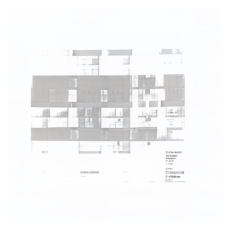

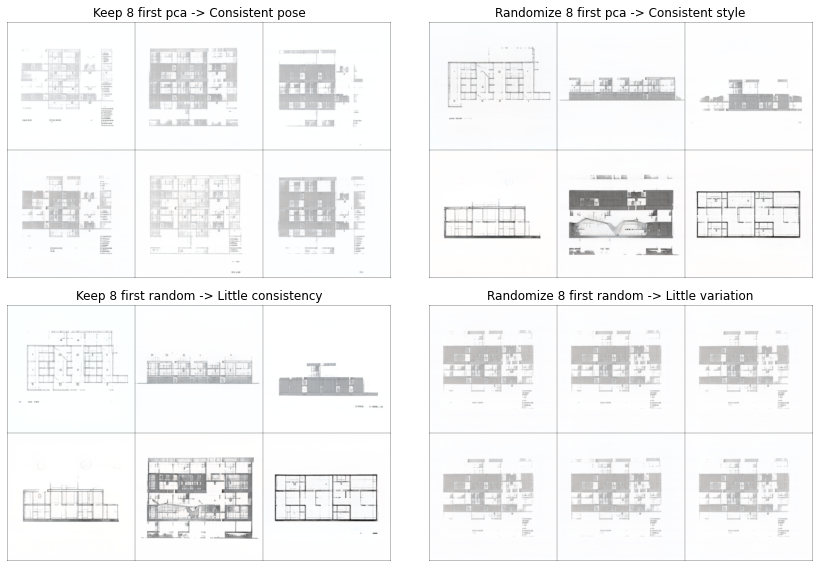

../models/Adaily_B/torch_official/stylegan2_Adaily_1024.pt
Not cached
[08.05 18:53] Computing stylegan2-Adaily_B_style_ipca_c512_n1000000_w.npz
Reusing InstrumentedModel instance
Using W latent space
Feature shape: torch.Size([1, 512])
B=500, N=1000000, dims=512, N/dims=1953.1


Fitting batches (NB=2000): 100%|##########| 500/500 [03:01<00:00,  2.75it/s]


Total time: 0:03:31.028250
Seeds: 1257084100 - 1257084106


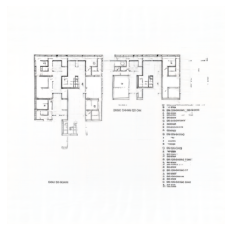

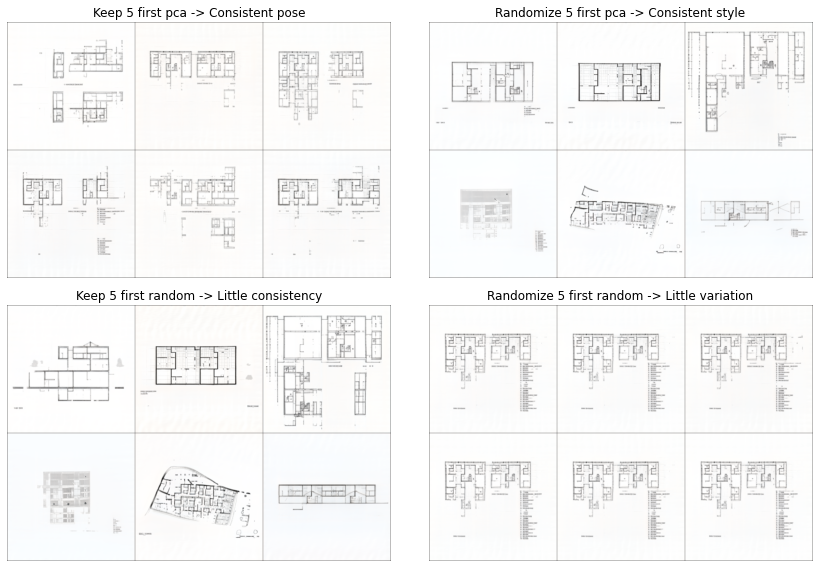

In [6]:
# generate PCA figures
generate('StyleGAN2', 'Adaily_A', seed=1866827965, trunc=0.55, N=8)

generate('StyleGAN2', 'Adaily_B', seed=1257084100, trunc=0.7, N=5)